# Preliminary analysis of MD Trajectories

In [1]:
import pytraj as pyt
import nglview
import ipywidgets
import seaborn as sns
import pandas as pd
import numpy as np
import gc
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

Load the **list of residues belonging to:**
1. The **secondary structure** (Pisani et al., 2016)
2. The protein's **active site** (pocket)

In [2]:
from helper_modules.protein_subsequences import get_pisani_residues, \
                get_pocket_residues, get_secondary_structure_residues

# Create the atom selection masks
mask_secnd_strc = '(:' + get_secondary_structure_residues(sep = ',') + ')&(@CA)'
mask_pisani     = '(:' + get_pisani_residues(sep = ',') + ')&(@CA)'
mask_pkt_Ca     = '(:' + get_pocket_residues(sep = ',') + ')&(@CA)'
mask_pkt_noHs   = '(:' + get_pocket_residues(sep = ',') + ')&!(@H=)'

In [3]:
# Visualize the main atom selections
mask_pkt_noHs

'(:8,9,10,11,12,13,14,15,16,17,18,19,30,31,32,33,64,65,79,80,81,82,83,84,85,86,87,88,89,90,129,130,131,132,133,134,143,144,145,146)&!(@H=)'

### Directory of MD trajectories

- The structure of the Directory containing the MD trajectories is the following:

In [4]:
WD = '../../data/md_trajectories/'


```bash
.
├── ETA_systems
│   ├── rep_1
│   │   ├── 1fin
│   │   │   ├── em
│   │   │   ├── md
│   │   │   │   ├── md_imaged_noWAT.gro
│   │   │   │   ├── md_imaged_noWAT.trr
│   │   │   │   └── ... (other files: .trr, .cpt, .edr, .log, etc)
│   │   │   ├── npt
│   │   │   ├── nvt
│   │   ├── 3pxf
│   │   ├── 4fku
│   │   └── 5a14
│   ├── rep_2
│   └── rep_3
├── ISO_systems
│   └── ...
├── LIG_systems
│   └── ...
├── MAM_systems
│   └── ...
└── WAT_systems
    └── ...
```

## Gromacs preprocessing steps

```python
# Convert .gro to .pdb
for i in */*/*/*.gro; do echo $i; gmx editconf -f $i -o ${i%.gro}.pdb; done

for i in */*/*/md/md_imaged_noWAT.gro; do echo $i; gmx editconf -f $i -o ${i%.gro}.pdb; done
```

### Load the trajectories using `pytraj`

1. Load each trajectory.
2. Perform RMSD using the atom selection mask defined above.
    - Use the initial structure as the reference
3. Compute the radius of gyration using the $C \alpha$ of the secondary structure.

In [5]:
from helper_modules.run_or_load import run_or_load_joblib

In [6]:
%%time
# Systems
SYSTEMS = ['WAT', 'LIG', 'ETA', 'ISO', 'MAM']
PDB_IDS = ['1fin' , '4fku', '3pxf', '5a14']
REPS    = [1, 2, 3]
MD_FILE_BASENAME = 'md_imaged_noWAT'


def do_md_analysis():
    results_dict = {}

    for system in SYSTEMS:
        results_dict[system] = {}
        for rep in REPS:
            results_dict[system][f'rep_{rep}'] = {}
            for pdb_id in PDB_IDS:
                current_dir = f'{WD}/{system}_systems/rep_{rep}/{pdb_id}/'
                # Reference (initial) structure (always from the same rep)
                ref_path  = f'{current_dir}/{pdb_id}-{system}.pdb'
                REF_PDB   = pyt.iterload(ref_path, top = ref_path) 
                # Load the trajectory
                pdb_path  = f'{current_dir}/md/{MD_FILE_BASENAME}.pdb'
                traj_path = f'{current_dir}/md/{MD_FILE_BASENAME}.trr'
                traj = pyt.iterload(traj_path, top = pdb_path)
                n_frames = traj.n_frames

                #**********************************
                # Trajectory Analysis using pytraj
                #**********************************
                # RMSD of Ca atoms of Secondary Structure
                rmsd_sec    = pyt.rmsd(traj, mask = mask_secnd_strc,  
                                       ref = REF_PDB)
                # Radius of gyration (all heavy atoms)
                rgyr = pyt.radgyr(traj, mask = mask_secnd_strc)

                # RMSD of Ca atoms of Pisani residues
                rmsd_pisani = pyt.rmsd(traj, mask = mask_pisani,  
                                       ref = REF_PDB)
                # RMSD of Pocket residues
                rmsd_pkt_Ca   = pyt.rmsd(traj, 
                                         mask = mask_pkt_Ca, 
                                         ref  = REF_PDB)
                rmsd_pkt_noHs = pyt.rmsd(traj, 
                                         mask = mask_pkt_noHs, 
                                         ref  = REF_PDB)

                # For LIG systems
                if system == 'LIG':
                    pyt.rmsd(traj, mask = '(:LIG)|' + mask_pkt_noHs)
                    # Lig-pocket distance 
                    pkt_lig_dist = pyt.distance(traj, 
                                                mask = f':LIG {mask_pkt_noHs}')
                    # Lig RMSD (pocket alignment using heavy atoms)
                    pyt.align(traj, mask = mask_pkt_noHs, ref = REF_PDB)
                    rmsd_lig = pyt.rmsd_nofit(traj, 
                                              mask = '(:LIG)&!(@H=)', 
                                              ref = REF_PDB)
                    # Pocket RMSD (ligand alignment)
                    pyt.align(traj, mask = '(:LIG)&!(@H=)', ref = REF_PDB)
                    rmsd_pkt_lig = pyt.rmsd_nofit(traj, 
                                                  mask = mask_pkt_noHs, 
                                                  ref = REF_PDB)
                else:
                    pkt_lig_dist = np.array(n_frames * [None])
                    rmsd_lig     = np.array(n_frames * [None])
                    rmsd_pkt_lig = np.array(n_frames * [None])

                # Properties related to types of conformations
                # To evaluate whether the conformation is open
                aC_helix, b4b5_sheets = ':46-57', ':66-72,75-81'
                aC_b4b5_dist = pyt.distance(traj, f'{aC_helix} {b4b5_sheets}')
                # To evaluate if the salt bridge between LYS33-GLU51 exists
                lys33_glu51_dist = pyt.distance(traj, ':33@NZ :51@CD')
                # The phi angle of ASP145 (DFG-out conf)
                phiAsp145_angle = pyt.calc_phi(traj, resrange = '145')[0].values

                # Save the values into the final dictionary
                results_dict[system][f'rep_{rep}'][pdb_id] = {
                    'RMSD_secCa'       : rmsd_sec,
                    'RMSD_pisaniCa'    : rmsd_pisani,
                    'RMSD_pktCa'       : rmsd_pkt_Ca,
                    'RMSD_pktHvyAtms'  : rmsd_pkt_noHs,
                    'Rgyr_secCa'       : rgyr,
                    'Dist_ProtLig'     : pkt_lig_dist,
                    'RMSD_lig_pktFit'  : rmsd_lig,
                    'RMSD_pkt_ligFit'  : rmsd_pkt_lig,
                    'Dist_aC_b4b5'     : aC_b4b5_dist,
                    'Dist_Lys33_Glu51' : lys33_glu51_dist,
                    'Angle_Lys33_Glu51': phiAsp145_angle
                }

                # To evaluate 

                del traj
                gc.collect()
                print(system, pdb_id)
    return results_dict

@run_or_load_joblib
def SAVE_do_md_analysis(filename):
    return do_md_analysis()

# Save to a file
results_dict = SAVE_do_md_analysis(f'./df_md_analysis.joblib')

File loaded: ./df_md_analysis.joblib
CPU times: user 82.8 ms, sys: 16.4 ms, total: 99.2 ms
Wall time: 148 ms


# Visualization

1. Gather the results into a `DataFrame`

In [7]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set(style = 'ticks', context = 'talk')

In [8]:
def iterdict(d, keys = [], columns = []):
    for k,v in d.items():        
        if isinstance(v, dict):
            keys.append(k)
            iterdict(v, keys, columns)
            keys.pop()
        else:        
            keys.append(k)
            key_str = '-'.join(keys)
            columns.append({key_str: v})
            keys.pop()
    return columns   

def get_md_analysis_prop(prop):
    _df = df_md.query(f'prop == "{prop}"')\
            .reset_index().drop('prop', axis = 1)
    _df = _df.melt(value_vars = range(0, 4000), 
             value_name = prop,
             var_name = "time (ns)",
             id_vars = ["system", "rep", "conf"])\
             .sort_values(["system", "rep", "conf"])
    _df["time (ns)"] = _df["time (ns)"] / 20
    _df = _df.infer_objects()
    return _df

In [9]:
df_md = pd.concat([pd.DataFrame(i) for i in 
                iterdict(results_dict, 
                         keys = [], columns = [])], axis = 1)
idx = df_md.columns.str.split('-', expand=True)
df_md.columns = idx
df_md = df_md.T
df_md.index.names = ['system', 'rep', 'conf', 'prop']

In [10]:
df_md.index.get_level_values(3).unique()

Index(['RMSD_secCa', 'RMSD_pisaniCa', 'RMSD_pktCa', 'RMSD_pktHvyAtms',
       'Rgyr_secCa', 'Dist_ProtLig', 'RMSD_lig_pktFit', 'RMSD_pkt_ligFit',
       'Dist_aC_b4b5', 'Dist_Lys33_Glu51', 'Angle_Lys33_Glu51'],
      dtype='object', name='prop')

### Visualize the four reference strucutures using `nglview`

| Conformation Type | PDB Entry       |  Color |  
| :- |:------------- | :--
|**Active**|<mark style="background-color: #FFBAAD">1fin</mark>| red | 
|**Inactive** Src-Like|<mark style="background-color: #B0E6EA">4kku</mark>| blue |
|**Inactive** Open|<mark style="background-color: #FAE5BF">3pxf</mark>| orange |
|**Inactive** DFG-out|<mark style="background-color: #D5BFFA">5a14</mark>| violet |


## RMSD of the secondary structure (Å)
- RMSD in angstroms
- For each PDB_id system, its crystal structure was used as the reference.

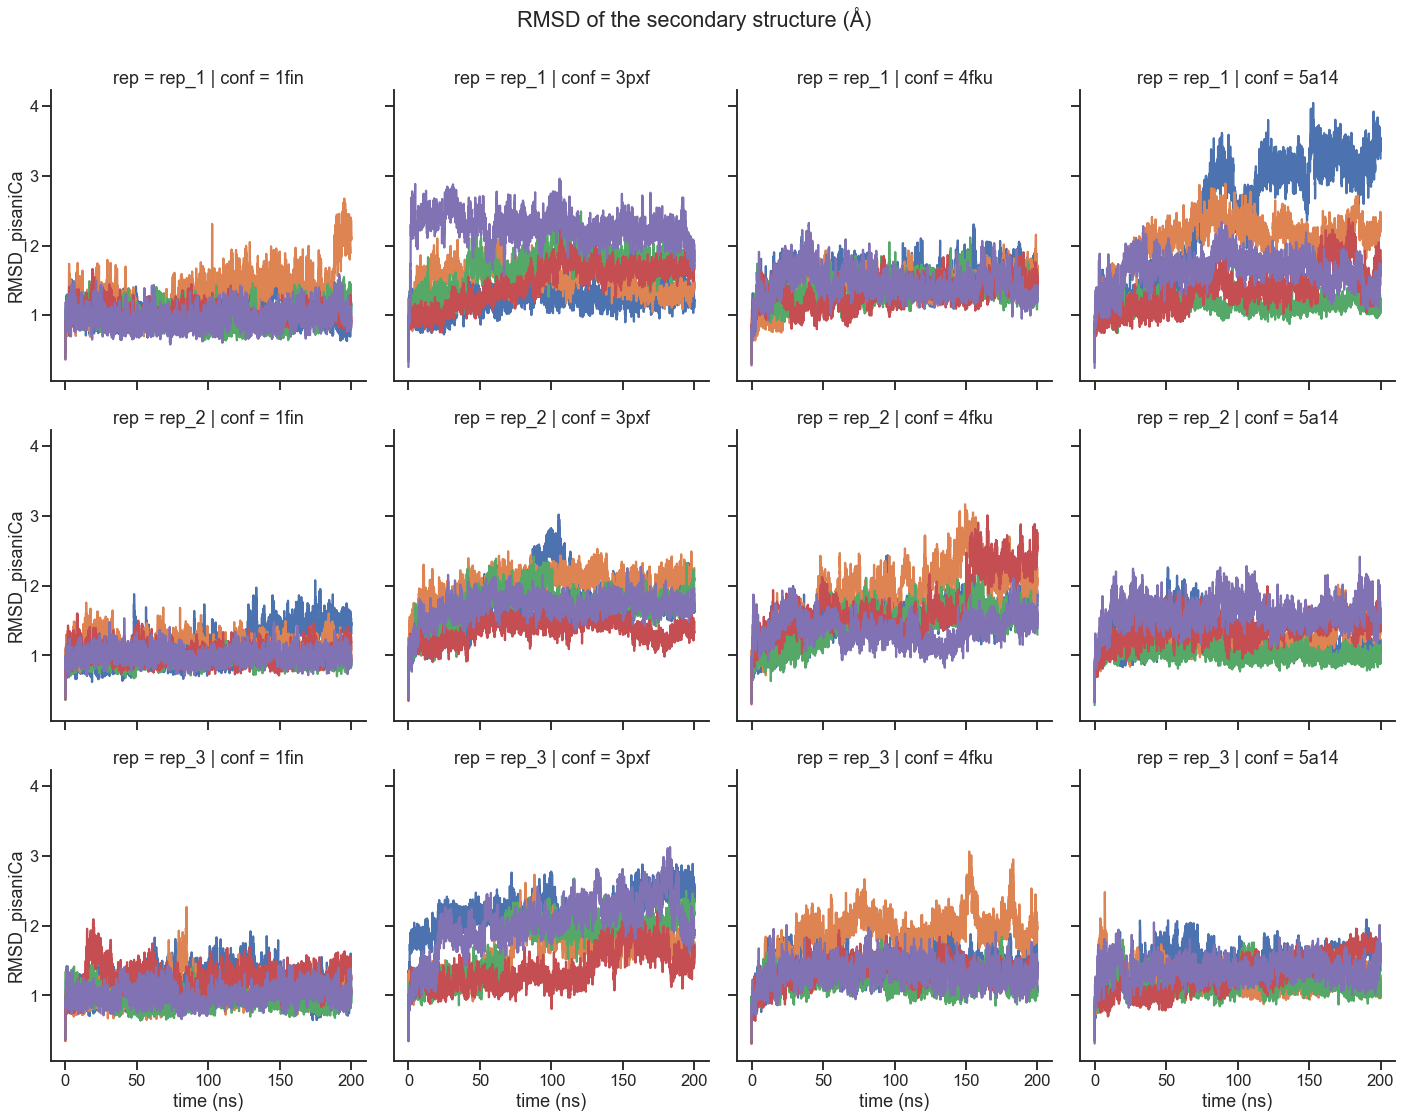

In [11]:
prop = "RMSD_pisaniCa"

_df = get_md_analysis_prop(prop)
g = sns.relplot(x="time (ns)", y=prop,
                hue="system", col="conf", 
                row = 'rep',
                kind = 'line',
                data = _df, legend = False)
plt.suptitle('RMSD of the secondary structure (Å)', y = 1.04)
plt.show()

## RMSD of the active site (Å)
- RMSD in angstroms
- For each PDB_id system, its crystal structure was used as the reference.

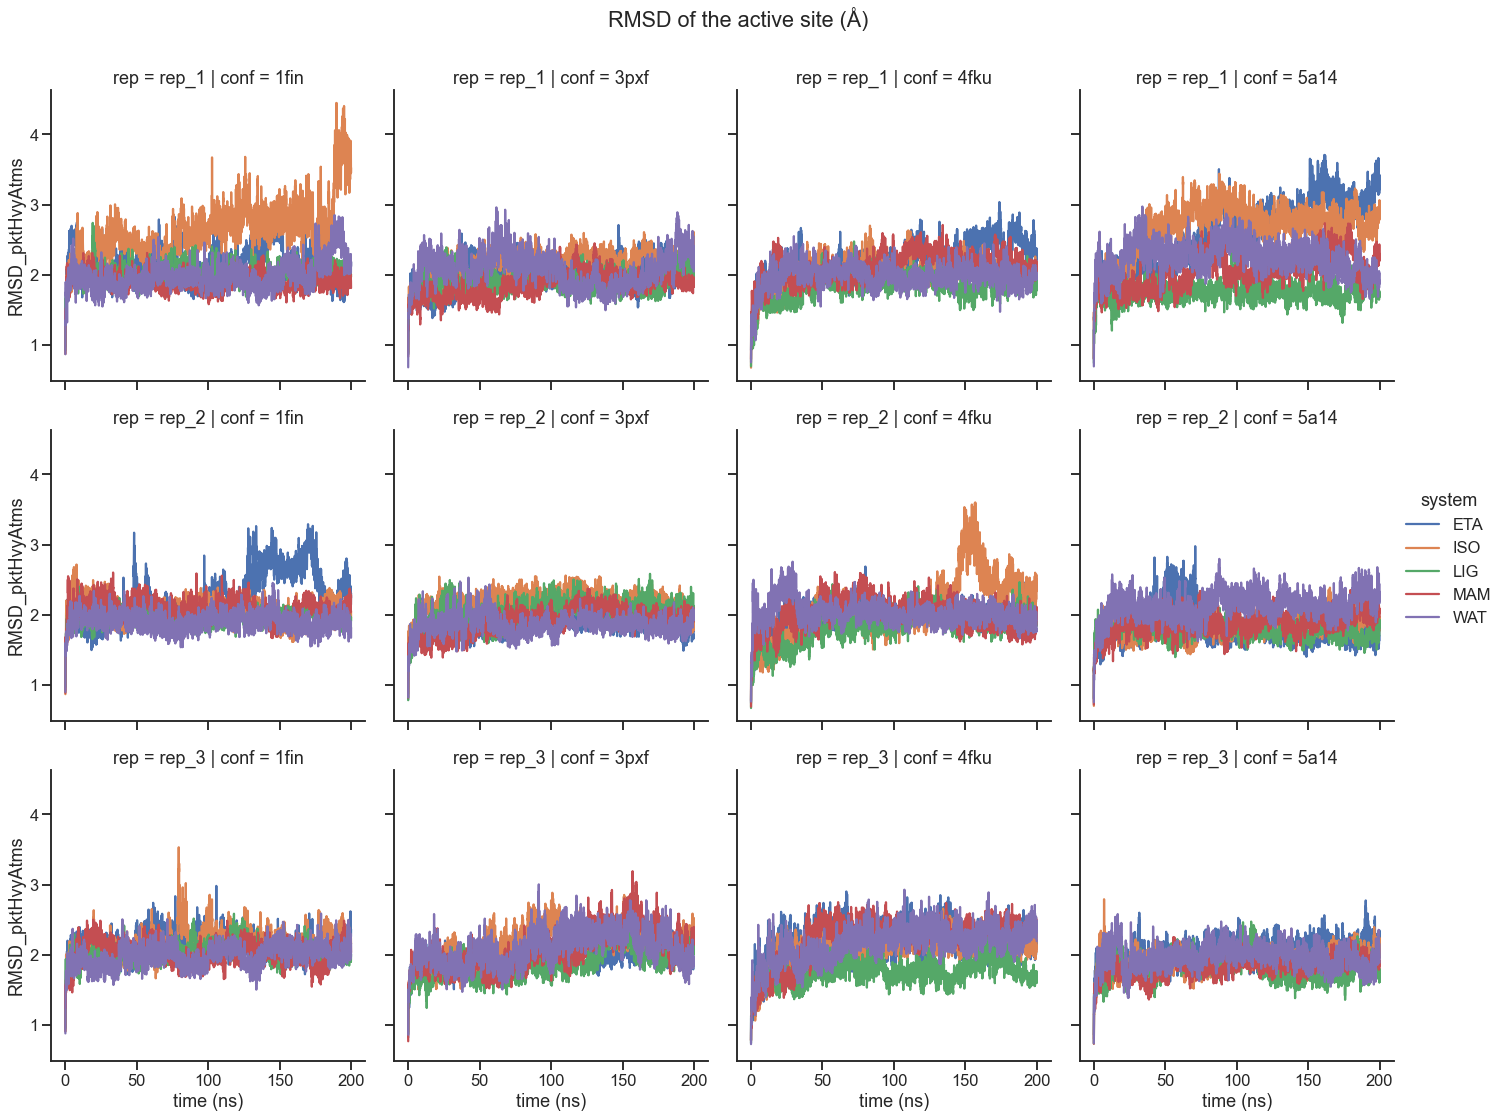

In [12]:
prop = "RMSD_pktHvyAtms"

_df = get_md_analysis_prop(prop)
g = sns.relplot(x="time (ns)", y=prop,
                hue="system", col="conf", 
                row = 'rep',
                kind = 'line',
                data = _df)
plt.suptitle('RMSD of the active site (Å)', y = 1.04)
plt.show()

## Radius of Gyration (Å)
- Rgyr in angstroms

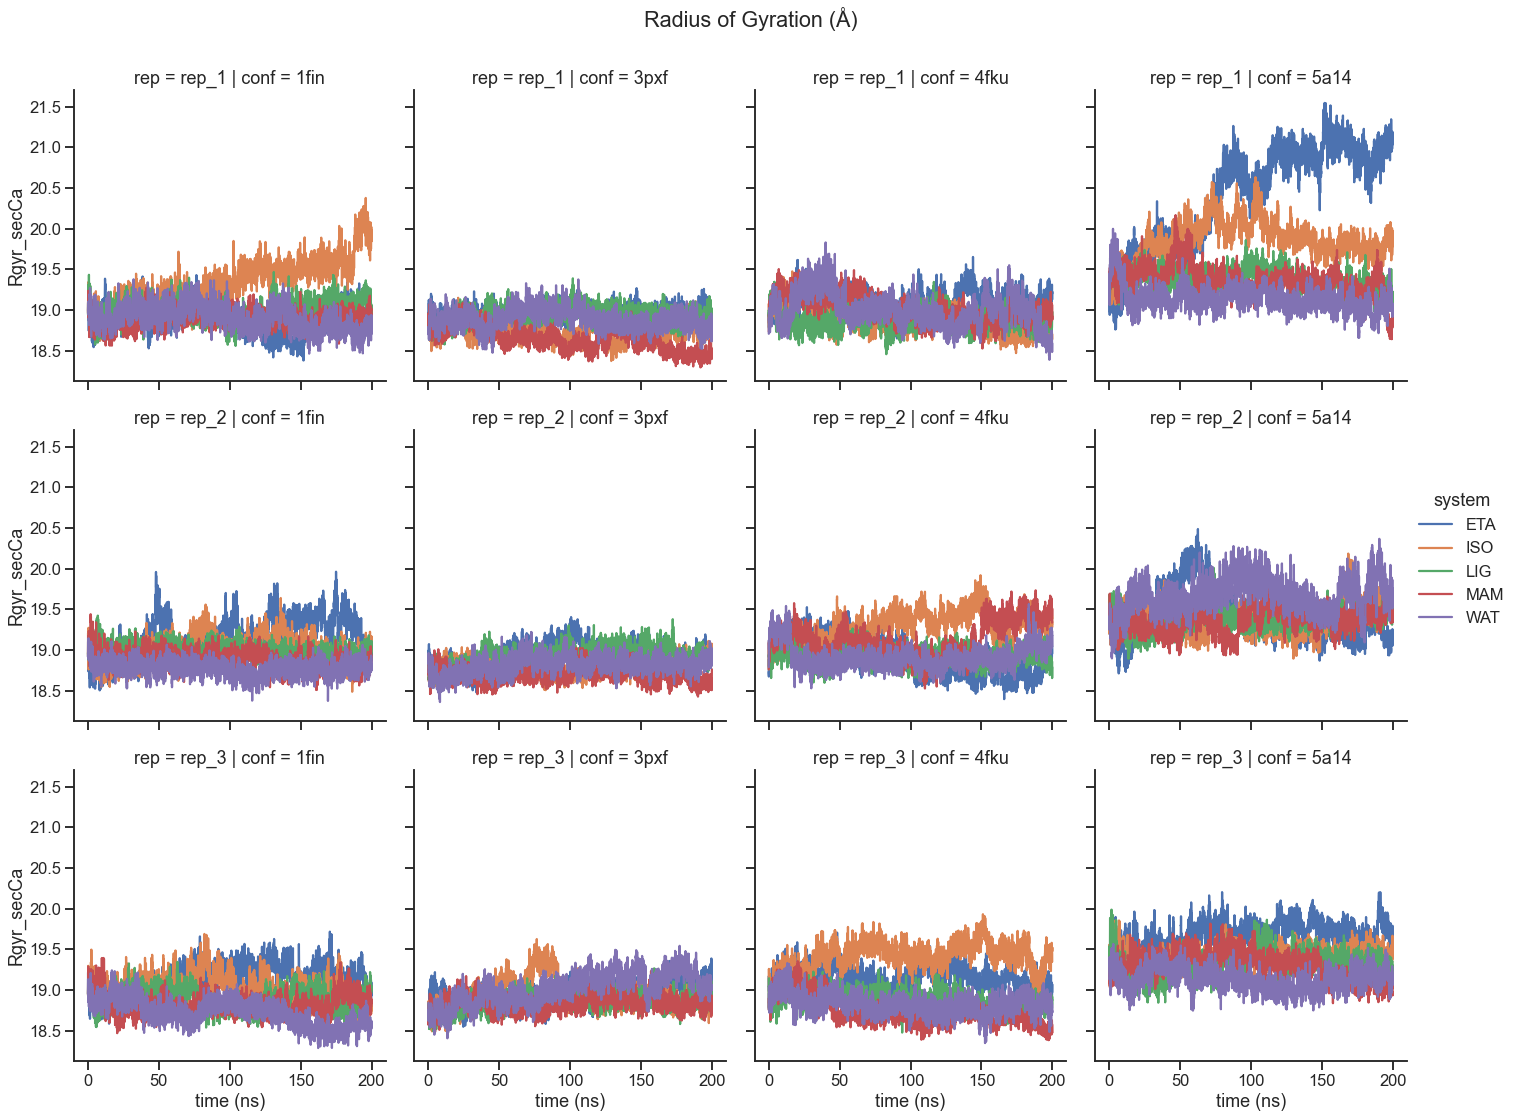

In [13]:
prop = "Rgyr_secCa"

_df = get_md_analysis_prop(prop)
g = sns.relplot(x="time (ns)", y=prop,
                hue="system", col="conf", 
                row = 'rep',
                kind = 'line',
                data = _df)
plt.suptitle('Radius of Gyration (Å)', y = 1.04)
plt.show()

## Distance (Å) between $\alpha$C helix and $\beta_4 \beta_5$ sheets

/Users/joelricci/miniconda/envs/biobb/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120572 (\N{MATHEMATICAL ITALIC SMALL ALPHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/joelricci/miniconda/envs/biobb/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120573 (\N{MATHEMATICAL ITALIC SMALL BETA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


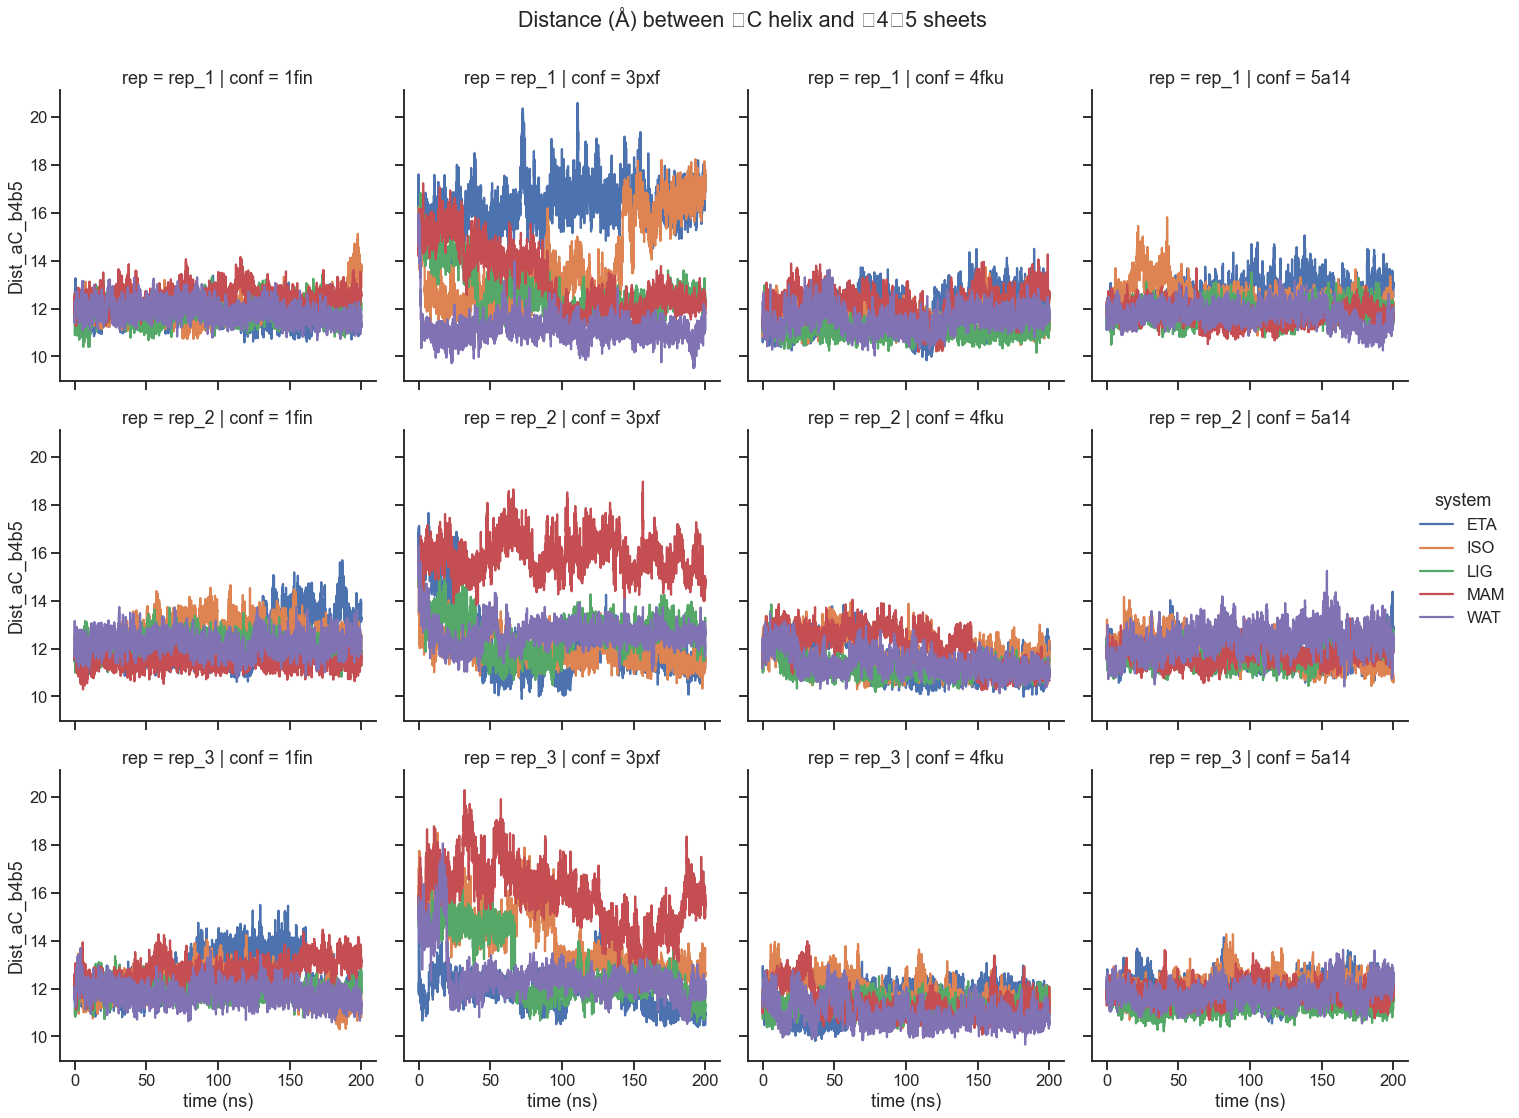

In [14]:
prop = "Dist_aC_b4b5"

_df = get_md_analysis_prop(prop)
g = sns.relplot(x="time (ns)", y=prop,
                hue="system", col="conf", 
                row = 'rep',
                kind = 'line',
                data = _df)
plt.suptitle('Distance (Å) between aC helix and b4b5 sheets', y = 1.04)
plt.show()

## Distance (Å) between LYS33-GLU51

- Measure the distance between atoms `:33@NZ` and `:51@CD` to evaluate the salt bridge between LYS33-GLU51

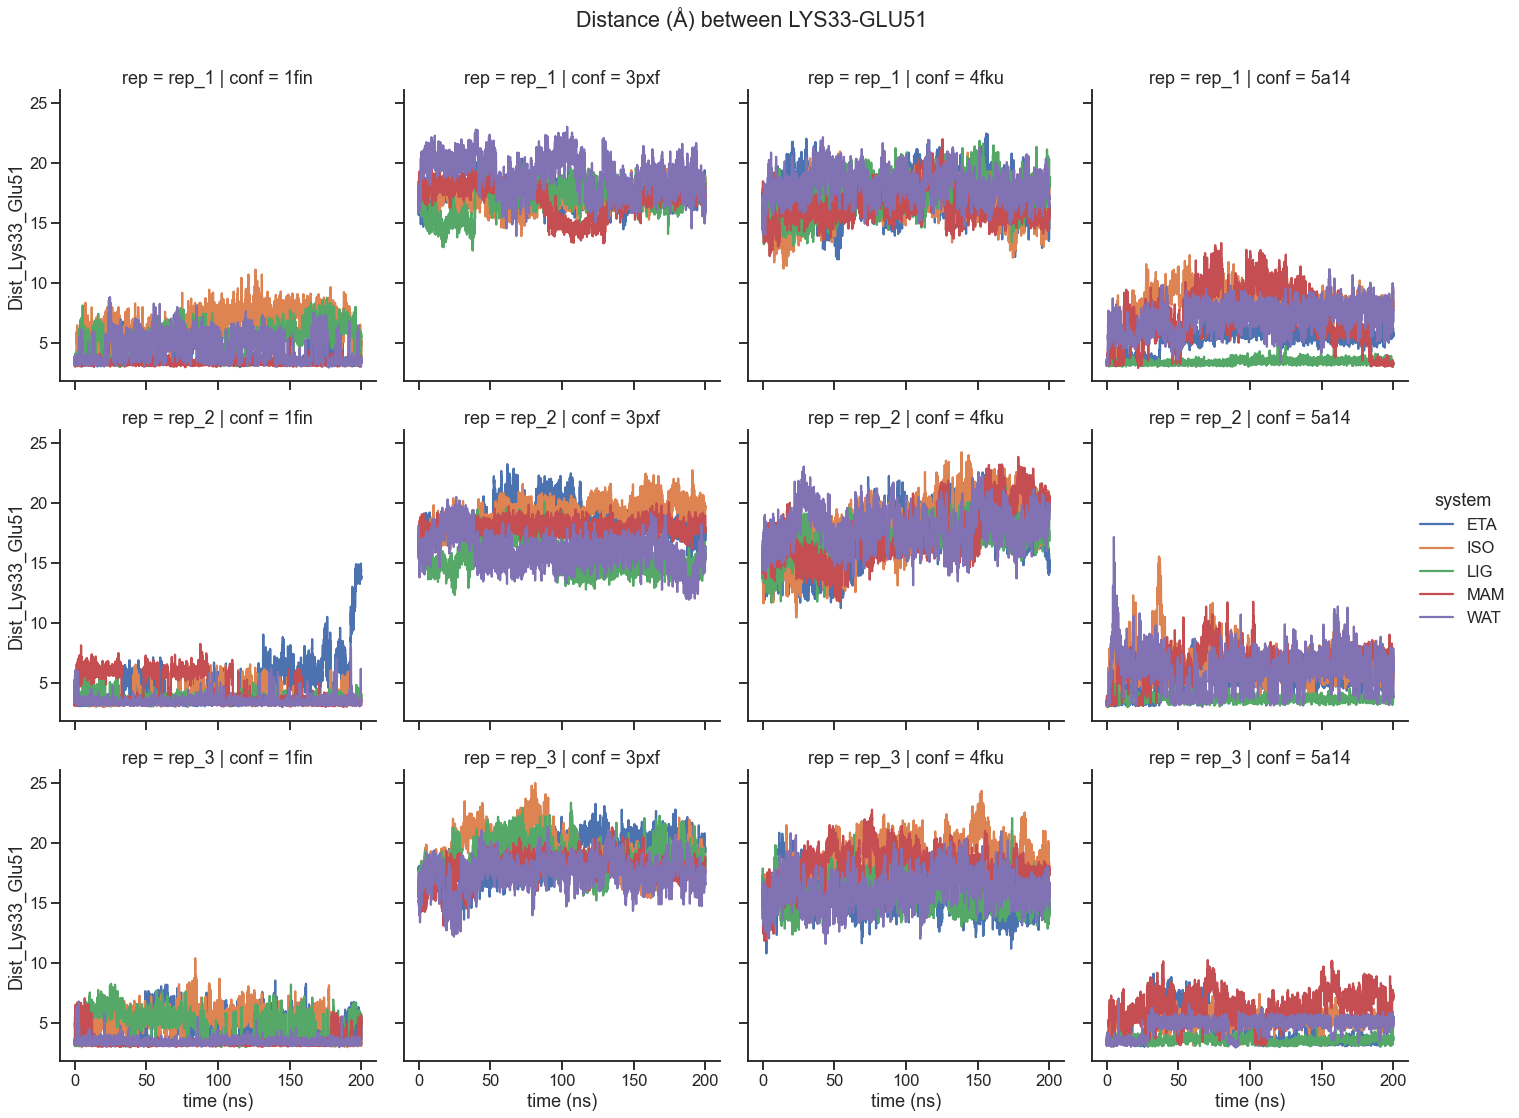

In [15]:
prop = "Dist_Lys33_Glu51"

_df = get_md_analysis_prop(prop)
g = sns.relplot(x="time (ns)", y=prop,
                hue="system", col="conf", 
                row = 'rep',
                kind = 'line',
                data = _df)
plt.suptitle('Distance (Å) between LYS33-GLU51', y = 1.04)
plt.show()

## For LIG systems
### Distance (Å) between Pocket's atoms  and Ligand geometric centers

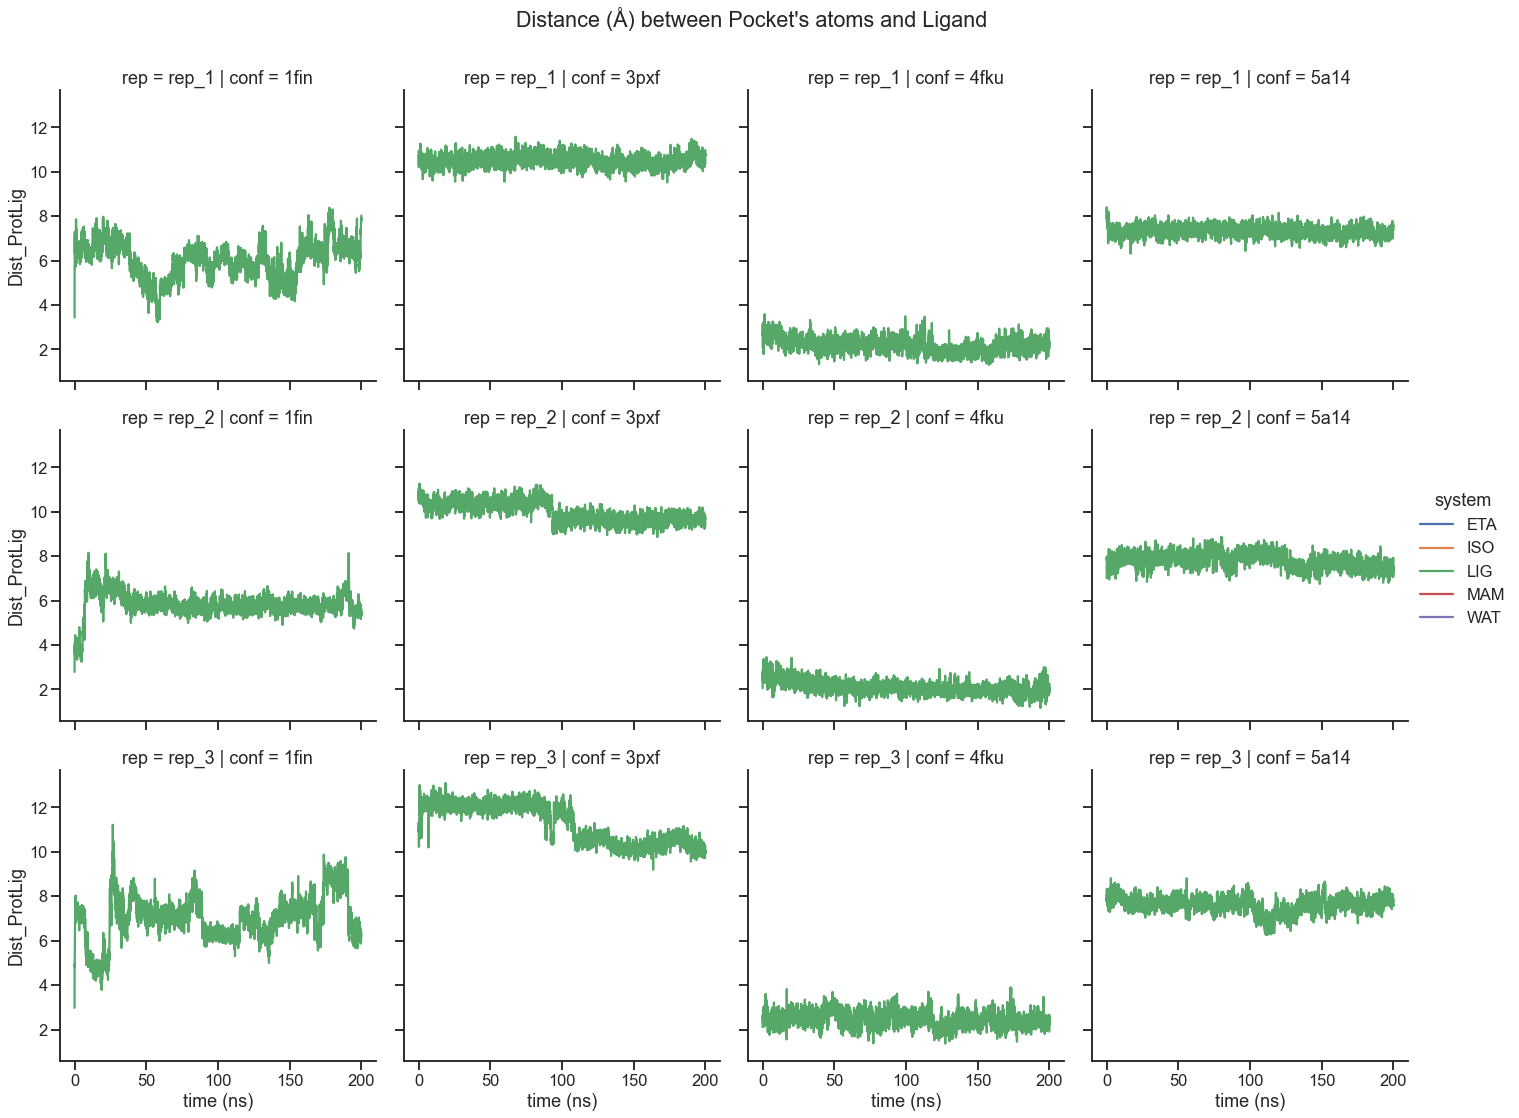

In [16]:
prop = "Dist_ProtLig"

_df = get_md_analysis_prop(prop)
g = sns.relplot(x="time (ns)", y=prop,
                hue="system", col="conf", 
                row = 'rep',
                kind = 'line',
                data = _df)
plt.suptitle("Distance (Å) between Pocket's atoms and Ligand", y = 1.04)
plt.show()

### Ligand RMSD (Å) after Protein's pocket alignment
- Heavy atoms of the ligand were considered to compute RMSD.
- Heavy atoms of the protein pocket were used to perform the structure alignment.

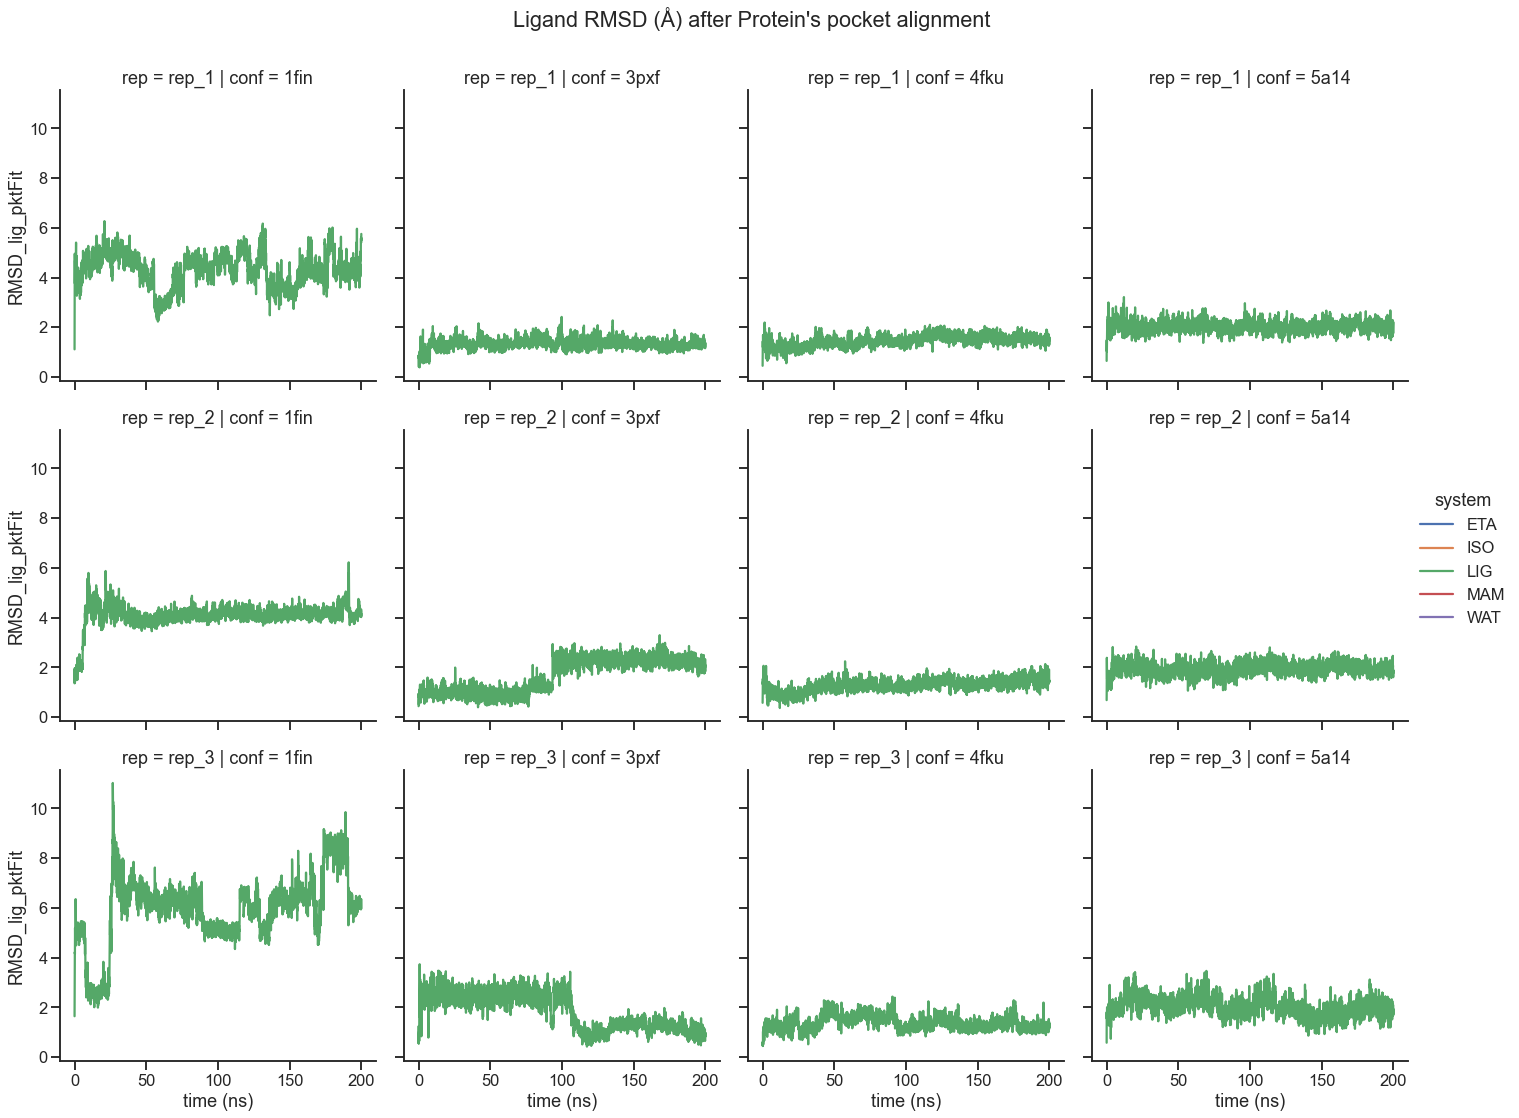

In [17]:
prop = "RMSD_lig_pktFit"

_df = get_md_analysis_prop(prop)
g = sns.relplot(x="time (ns)", y=prop,
                hue="system", col="conf", 
                row = 'rep',
                kind = 'line',
                data = _df)
plt.suptitle("Ligand RMSD (Å) after Protein's pocket alignment", y = 1.04)
plt.show()

### Protein's pocket RMSD (Å) after Ligand alignment
- Heavy atoms of the protein pocket were considered to compute RMSD. 
- Heavy atoms of the ligand were used to perform the structure alignment.

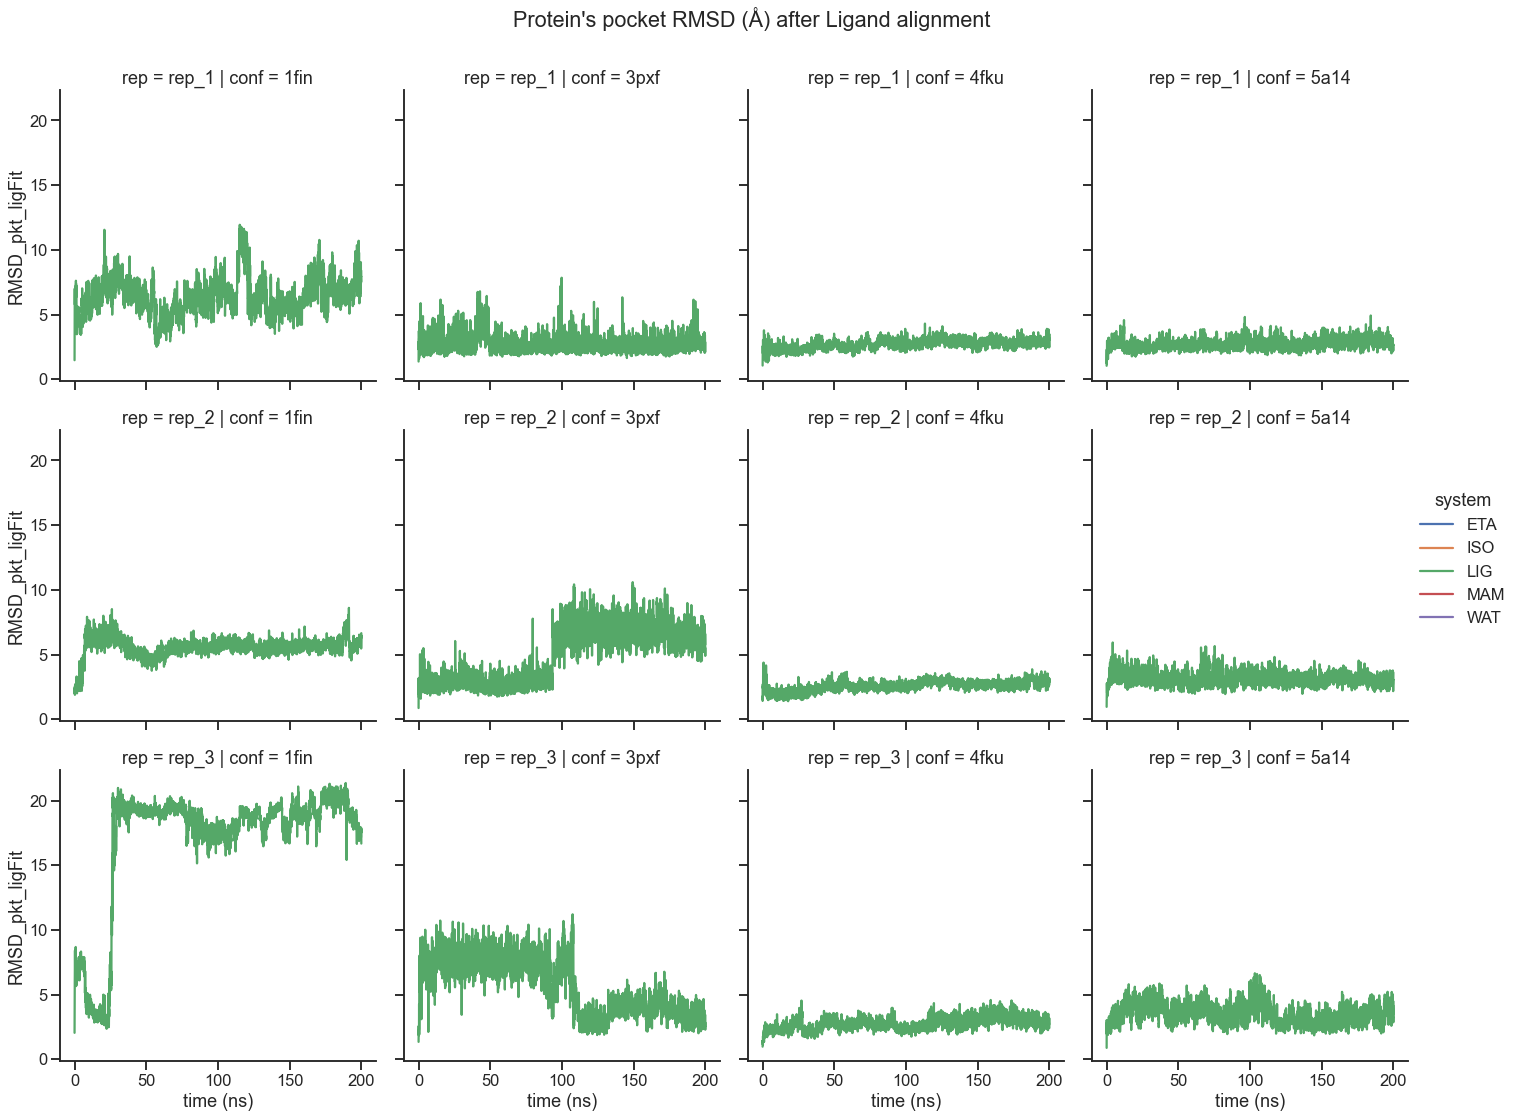

In [18]:
prop = "RMSD_pkt_ligFit"

_df = get_md_analysis_prop(prop)
g = sns.relplot(x="time (ns)", y=prop,
                hue="system", col="conf", 
                row = 'rep',
                kind = 'line',
                data = _df)
plt.suptitle("Protein's pocket RMSD (Å) after Ligand alignment", y = 1.04)
plt.show()

## Visualize an specific trajectory

In [19]:
pdb_id = '1fin'
system = 'LIG'
rep = 3

WD = '../../data/md_trajectories/'
pdb_path = f'{WD}/{system}_systems/rep_{rep}/{pdb_id}/md/md_imaged_noWAT.pdb'
traj_path = f'{WD}/{system}_systems/rep_{rep}/{pdb_id}/md/md_imaged_noWAT.trr'
traj_sample = pyt.load(traj_path, pdb_path)
# pyt.rmsd(traj_sample, mask = mask_pkt_Ca )
traj_sample = pyt.autoimage(traj_sample, mask = mask_pkt_Ca + '|(:LIG)')
view = nglview.show_pytraj(traj_sample)
view.clear_representations()
view.add_representation(repr_type='cartoon', 
                        selection='solute', 
                        color='sstruc')
view.add_representation(repr_type ='licorice', 
                        selection='LIG')
view

NGLWidget(max_frame=4000)